# Model subclassing and custom training loops

> In the section, we're going to look at ways to build fully customizable deep learning models and layers, as well as custom training loops. This is the summary of lecture "Customizing your model with Tensorflow 2" from Coursera.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Deep_Learning, Tensorflow]
- image: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

plt.rcParams['figure.figsize'] = (16, 10)
print('Tensorflow: v' + tf.__version__)

Tensorflow: v2.3.1


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

## Model subclassing

### Example

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

class MyModel(Model):
    def __init__(self, **kwargs):
        super(MyModel, self).__init__(**kwargs)
        self.dense = Dense(16)
        
    def call(self, inputs):
        return self.dense(inputs)
    
my_model = MyModel(name='my_model')

In [4]:
class MyModel(Model):
    def __init__(self, num_classes, **kwargs):
        super(MyModel, self).__init__(**kwargs)
        self.dense1 = Dense(16, activation='sigmoid')
        self.dense2 = Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        h = self.dense1(inputs)
        return self.dense2(h)
    
my_model = MyModel(10, name='my_model')

In [5]:
from tensorflow.keras.layers import Dropout

class MyModel(Model):
    def __init__(self, num_classes, **kwargs):
        super(MyModel, self).__init__(**kwargs)
        self.dense1 = Dense(16, activation='sigmoid')
        self.dropout = Dropout(0.5)
        self.dense2 = Dense(num_classes, activation='softmax')
        
    def call(self, inputs, training=False):
        h = self.dense1(inputs)
        h = self.dropout(h, training=training)
        return self.dense2(h)
    
my_model = MyModel(12, name='my_model')

### Coding Tutorial

#### Create a simple model using the model subclassing API

In [6]:
from tensorflow.keras.layers import Softmax, concatenate

# Build the model
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense_1 = Dense(64, activation='relu')
        self.dense_2 = Dense(10)
        self.dense_3 = Dense(5)
        self.softmax = Softmax()
        
    def call(self, inputs):
        x = self.dense_1(inputs)
        y1 = self.dense_2(inputs)
        y2 = self.dense_3(y1)
        concat = concatenate([x, y2])
        return self.softmax(concat)

In [7]:
# Print the model summary
model = MyModel()
model(tf.random.uniform([1, 10]))
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              multiple                  704       
_________________________________________________________________
dense_6 (Dense)              multiple                  110       
_________________________________________________________________
dense_7 (Dense)              multiple                  55        
_________________________________________________________________
softmax (Softmax)            multiple                  0         
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________


## Custom layers

### Example

In [8]:
from tensorflow.keras.layers import Layer

class LinearMap(Layer):
    def __init__(self, input_dim, units):
        super(LinearMap, self).__init__()
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(initial_value=w_init(shape=(input_dim, units)))
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w)

In [9]:
linear_layer = LinearMap(3, 2)
inputs = tf.ones((1, 3))
linear_layer(inputs)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.11157431, -0.04011689]], dtype=float32)>

In [10]:
linear_layer.weights

[<tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
 array([[ 0.02235899,  0.00318802],
        [ 0.06816813, -0.04018618],
        [ 0.02104719, -0.00311874]], dtype=float32)>]

Or

In [11]:
class LinearMap(Layer):
    def __init__(self, input_dim, units):
        super(LinearMap, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal')
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w)

In [12]:
class MyModel(Model):
    def __init__(self, hidden_units, outputs, **kwargs):
        super(MyModel, self).__init__(**kwargs)
        self.dense = Dense(hidden_units, activation='sigmoid')
        self.linear = LinearMap(hidden_units, outputs)
        
    def call(self, inputs):
        h = self.dense(inputs)
        return self.linear(h)
    
my_model = MyModel(64, 12, name='my_custom_model')

### Coding Tutorial

#### Create custom layers

In [13]:
class MyLayer(Layer):
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal')
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros')
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
dense_layer = MyLayer(3, 5)
x = tf.ones((1, 5))

In [14]:
dense_layer(x)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.18329121, -0.06060172, -0.03365979]], dtype=float32)>

In [15]:
dense_layer.weights

[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
 array([[-0.08679068,  0.01365799,  0.01223046],
        [ 0.00813669, -0.04940577, -0.09833629],
        [-0.0928591 ,  0.02693981,  0.00356329],
        [ 0.05308659,  0.02836417,  0.06213455],
        [-0.06486471, -0.08015792, -0.01325181]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

In [16]:
# Specify trainable weights
class MyLayer(Layer):
    def __init__(self, units, input_dim, trainable=True):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal',
                                 trainable=trainable)
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros',
                                 trainable=trainable)
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
dense_layer = MyLayer(3, 5, False)

In [17]:
print('trainable weights: ', len(dense_layer.trainable_weights))
print('non-trainable weights: ', len(dense_layer.non_trainable_weights))

trainable weights:  0
non-trainable weights:  2


In [18]:
# Create a custom layer to accumulate means of output values
class MyLayerMean(Layer):
    def __init__(self, units, input_dim):
        super(MyLayerMean, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal')
        self.b = self.add_weight(shape=(units, ),
                                 initializer='zeros')
        self.sum_activation = tf.Variable(initial_value=tf.zeros((units, )),
                                          trainable=False)
        self.number_call = tf.Variable(initial_value=0, trainable=False)
        
    def call(self, inputs):
        activations = tf.matmul(inputs, self.w) + self.b
        self.sum_activation.assign_add(tf.reduce_sum(activations, axis=0))
        self.number_call.assign_add(inputs.shape[0])
        return activations, self.sum_activation / tf.cast(self.number_call, tf.float32)
    
dense_layer = MyLayerMean(3, 5)

In [19]:
y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means)

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means)

tf.Tensor([ 0.0081684   0.07423085 -0.04404428], shape=(3,), dtype=float32)
tf.Tensor([ 0.0081684   0.07423085 -0.04404428], shape=(3,), dtype=float32)


In [20]:
# Create a Dropout layer as a custom layer
class MyDropout(Layer):
    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        return tf.nn.dropout(inputs, rate=self.rate)

#### Implement the custom layers into a model

In [21]:
class MyModel(Model):
    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()
        
    def call(self, inputs):
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)

In [22]:
model = MyModel(64, 10000, 64, 46)
model(tf.ones((1, 10000)))

<tf.Tensor: shape=(1, 46), dtype=float32, numpy=
array([[0.02363411, 0.00722982, 0.00433364, 0.01021433, 0.01522585,
        0.0096773 , 0.07354084, 0.08215816, 0.00386134, 0.02028561,
        0.05777054, 0.03187992, 0.01218679, 0.00561747, 0.00956095,
        0.00182258, 0.006732  , 0.01768909, 0.0383426 , 0.00859564,
        0.01869351, 0.05798897, 0.00814057, 0.00933855, 0.0273599 ,
        0.06257187, 0.00842152, 0.01366278, 0.01435281, 0.01921858,
        0.00738242, 0.00977533, 0.00408678, 0.01300202, 0.00544359,
        0.00716157, 0.00751841, 0.06742233, 0.00688019, 0.02562101,
        0.03329933, 0.00318435, 0.04262085, 0.01556576, 0.03001485,
        0.04091357]], dtype=float32)>

In [23]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_2 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout (MyDropout)       multiple                  0         
_________________________________________________________________
my_layer_3 (MyLayer)         multiple                  4160      
_________________________________________________________________
my_dropout_1 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_4 (MyLayer)         multiple                  2990      
_________________________________________________________________
softmax_1 (Softmax)          multiple                  0         
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
__________________________________________________

## Automatic differentiation

### Example

In [24]:
x = tf.constant(2.0)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = x ** 2
    grad = tape.gradient(y, x)

In [25]:
grad

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

In [26]:
x = tf.constant([0, 1, 2, 3], dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.reduce_mean(x ** 2)
    z = tf.math.sin(y)
    dz_dy = tape.gradient(z, y)
    
dz_dy

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9364567>

In [27]:
x = tf.constant([0, 1, 2, 3], dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.reduce_mean(x ** 2)
    z = tf.math.sin(y)
    dz_dy, dz_dx = tape.gradient(z, [y, x])
    
dz_dy

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9364567>

In [28]:
dz_dx

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.        , -0.46822834, -0.9364567 , -1.404685  ], dtype=float32)>

### Coding tutorial

#### Create synthetic data

In [29]:
# Create data from a noise contaminated linear model
def makeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n, ))
    noise = tf.random.normal(shape=(len(x), ), stddev=0.1)
    y = m * x + b + noise
    return x, y

X_train, y_train = makeNoisyData(1, 2)

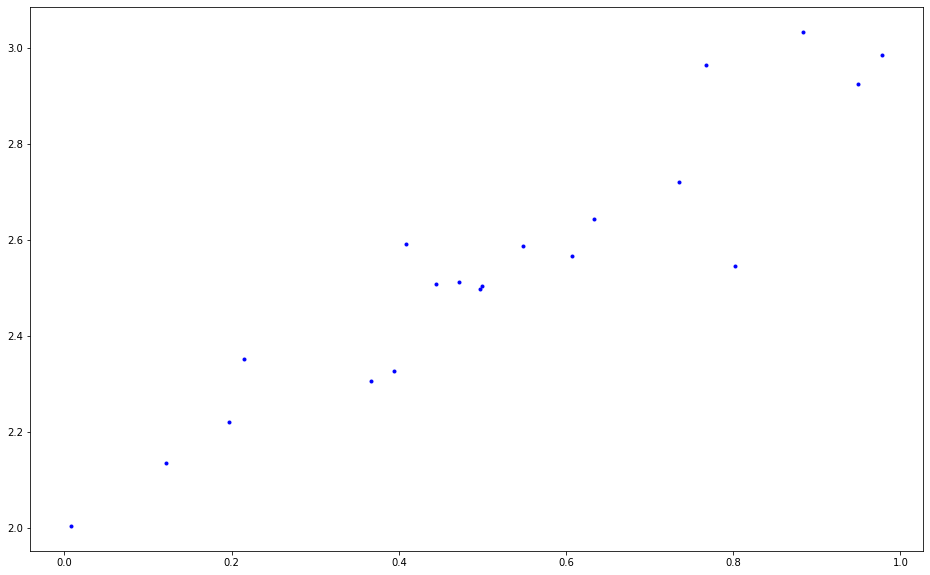

In [30]:
plt.plot(X_train, y_train, 'b.')
plt.show()

#### Define a linear regression model

In [31]:
# Build a custom layer for the linear regression model
class LinearLayer(Layer):
    def __init__(self):
        super(LinearLayer, self).__init__()
        self.m = self.add_weight(shape=(1, ), initializer='random_normal')
        self.b = self.add_weight(shape=(1, ), initializer='zeros')
        
    def call(self, inputs):
        return self.m * inputs + self.b
    
linear_regression = LinearLayer()

In [32]:
linear_regression(X_train)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-0.00615652, -0.0189626 , -0.01980308, -0.03056775, -0.02397843,
       -0.00671741, -0.02295232, -0.01553419, -0.01474398, -0.02761876,
       -0.01147347, -0.00024076, -0.01559051, -0.01387256, -0.0127605 ,
       -0.0250767 , -0.00378366, -0.01713622, -0.02964243, -0.01231781],
      dtype=float32)>

In [33]:
linear_regression.weights

[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-0.03124008], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

#### Define the loss function

In [34]:
def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))

starting_loss = SquaredError(linear_regression(X_train), y_train)
print('Starting loss', starting_loss.numpy())

Starting loss 6.6486845


#### Train and plot the model

In [35]:
learning_rate = 0.05
steps = 25

for i in range(steps):
    with tf.GradientTape() as tape:
        predictions = linear_regression(X_train)
        loss = SquaredError(predictions, y_train)
        
    gradients = tape.gradient(loss, linear_regression.trainable_variables)
    
    linear_regression.m.assign_sub(learning_rate * gradients[0])
    linear_regression.b.assign_sub(learning_rate * gradients[1])
    
    print('Step {}, Loss {:.4f}'.format(i, loss.numpy()))

Step 0, Loss 6.6487
Step 1, Loss 5.0427
Step 2, Loss 3.8253
Step 3, Loss 2.9023
Step 4, Loss 2.2027
Step 5, Loss 1.6723
Step 6, Loss 1.2702
Step 7, Loss 0.9653
Step 8, Loss 0.7342
Step 9, Loss 0.5591
Step 10, Loss 0.4263
Step 11, Loss 0.3256
Step 12, Loss 0.2492
Step 13, Loss 0.1914
Step 14, Loss 0.1475
Step 15, Loss 0.1143
Step 16, Loss 0.0890
Step 17, Loss 0.0699
Step 18, Loss 0.0554
Step 19, Loss 0.0444
Step 20, Loss 0.0361
Step 21, Loss 0.0298
Step 22, Loss 0.0250
Step 23, Loss 0.0214
Step 24, Loss 0.0186


In [36]:
print('m: {}, trained m: {}'.format(1, linear_regression.m.numpy()))
print('b: {}, trained b: {}'.format(2, linear_regression.b.numpy()))

m: 1, trained m: [1.0233109]
b: 2, trained b: [1.9247386]


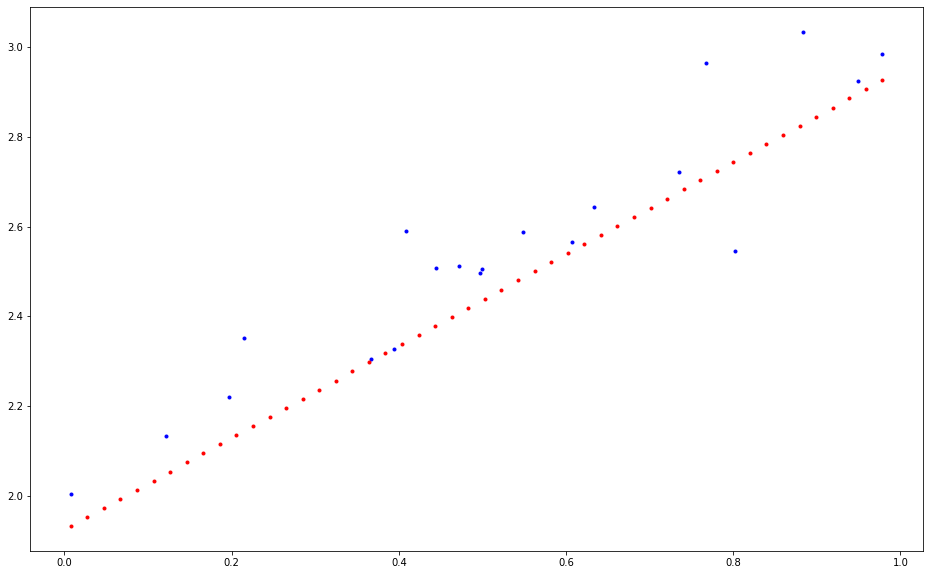

In [37]:
plt.plot(X_train, y_train, 'b.')
X_linear_regression = np.linspace(min(X_train), max(X_train), 50)
plt.plot(X_linear_regression, linear_regression.m * X_linear_regression + linear_regression.b, 'r.')
plt.show()

## Custom training loops

### Example

```python
my_model = MyModel()

def loss(y_pred, y):
    return tf.reduce_mean(tf.square(y_pred - y))

with tf.GradientTape() as tape:
    current_loss = loss(my_model(inputs), outputs)
    grads = tape.gradient(current_loss, my_model.trainable_variables)
```

```python

my_model = MyModel()

loss = tf.keras.losses.MeanSquaredError()

with tf.GradientTape() as tape:
    current_loss = loss(my_model(inputs), outputs)
    grads = tape.gradient(current_loss, my_model.trainable_variables)
```

```python
my_model = MyModel()
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9)

with tf.GradientTape() as tape:
    current_loss = loss(my_model(inputs), outputs)
    grads = tape.gradient(current_loss, my_model.trainable_variables)

optimizer.apply_gradients(zip(grads, my_model.trainable_variables))
```

```python

my_model = MyModel()

loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9)

batch_losses = []

for inputs, outputs in train_ds:
    with tf.GradientTape() as tape:
        current_loss = loss(my_model(inputs), outputs)
        grads = tape.gradient(current_loss, my_model.trainable_variables)
    batch_losses.append(current_loss)
    optimizer.apply_gradients(zip(grads, my_model.trainable_variables)) 
```

```python

my_model = MyModel()

loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9)


epoch_losses = []

for e in range(num_epochs):
    batch_losses = []

    for inputs, outputs in train_ds:
        with tf.GradientTape() as tape:
            current_loss = loss(my_model(inputs), outputs)
            grads = tape.gradient(current_loss, my_model.trainable_variables)
        batch_losses.append(current_loss)
        optimizer.apply_gradients(zip(grads, my_model.trainable_variables)) 
        
    epoch_losses.append(np.mean(batch_losses))
```

### Coding Tutorial

#### Build the model

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

class MyLayer(Layer):
    def __init__(self, units):
        super(MyLayer, self).__init__()
        self.units = units
        
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', name='kernel')
        self.b = self.add_weight(shape=(self.units, ), initializer='zeros', name='bias')
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
class MyDropout(Layer):
    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        return tf.nn.dropout(inputs, rate=self.rate)
    
class MyModel(Model):
    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        self.layer_1 = MyLayer(units_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3)
        self.softmax = Softmax()
        
    def call(self, inputs):
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)

In [39]:
model = MyModel(64, 64, 46)
model(tf.ones((1, 10000)))
model.summary()

Model: "my_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_5 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout_2 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_6 (MyLayer)         multiple                  4160      
_________________________________________________________________
my_dropout_3 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_7 (MyLayer)         multiple                  2990      
_________________________________________________________________
softmax_2 (Softmax)          multiple                  0         
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
__________________________________________________

#### Load the reuters dataset and define the class_names

In [40]:
from tensorflow.keras.datasets import reuters

(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

In [41]:
# Print the class of the first sample
print('Label: {}'.format(class_names[y_train[0]]))

Label: earn


#### Get the dataset word index

In [42]:
word_to_index = reuters.get_word_index()
invert_word_index = dict([(value, key) for key, value in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in X_train[0]])

print(text_news)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Preprocess the data

In [43]:
def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

X_train = bag_of_words(X_train)
X_test = bag_of_words(X_test)

print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (8982, 10000)
Shape of X_test: (2246, 10000)


#### Define the loss function and optimizer

In [44]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [45]:
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [46]:
import time
from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size=32)

train_loss_results = []
train_accuracy_results = []

weight_decay = 0.005

for e in range(10):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    for x, y in train_ds:
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        epoch_loss_avg(loss_value)
        epoch_accuracy(to_categorical(y), model(x))
    
    
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    print('Epoch {:03d}: Loss: {:3f}, Accuracy: {:.3%}'.format(e, epoch_loss_avg.result(), epoch_accuracy.result()))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss: 3.315004, Accuracy: 48.352%
Epoch 001: Loss: 1.920460, Accuracy: 60.521%
Epoch 002: Loss: 1.814415, Accuracy: 66.500%
Epoch 003: Loss: 1.780147, Accuracy: 67.969%
Epoch 004: Loss: 1.758146, Accuracy: 68.749%
Epoch 005: Loss: 1.727221, Accuracy: 69.617%
Epoch 006: Loss: 1.722336, Accuracy: 70.051%
Epoch 007: Loss: 1.716662, Accuracy: 70.775%
Epoch 008: Loss: 1.704199, Accuracy: 70.697%
Epoch 009: Loss: 1.703848, Accuracy: 70.931%


#### Evaluate the model

In [47]:
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size=32)

In [48]:
epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [49]:
for x, y in test_ds:
    loss_value = loss(model, x, y, weight_decay)
    epoch_loss_avg(loss_value)
    epoch_accuracy(to_categorical(y), model(x))
    
print('Test loss: {:.3f}'.format(epoch_loss_avg.result()))
print('Test accuracy: {:.3%}'.format(epoch_accuracy.result()))

Test loss: 1.847
Test accuracy: 68.032%


#### Plot the learning curves

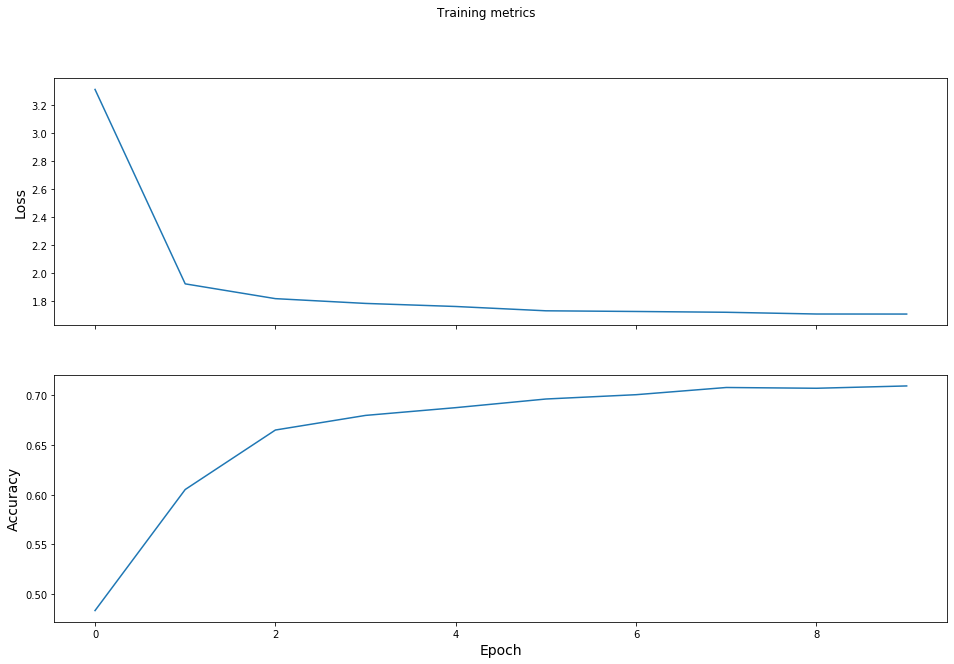

In [50]:
fig, axes = plt.subplots(2, sharex=True)
fig.suptitle('Training metrics')
axes[0].set_ylabel('Loss', fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel('Accuracy', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [51]:
y_pred = np.argmax(model(X_train[tf.newaxis, 30]), axis=1)[0]
print("Prediction: {}".format(class_names[y_pred]))
print('Label: {}'.format(class_names[y_train[30]]))

Prediction: trade
Label: grain


## Tracking metrics in custom training loops

In this section, you will learn how to track metrics such as accuracy within custom training loops. 

Tracking performance metrics is useful to check the performance of your model during and after training. Previously, we have passed in a list of metrics to the `model.fit` or `model.evaluate` methods when using the higher level APIs. However, we would still like to be able to evaluate our model on performance metrics in a custom training loop.

### Load the dataset

For this reading notebook we will use the Reuters dataset. The cells below load and process the dataset, and prepare it as `tf.data.Dataset` objects.

In [52]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=10000, skip_top=50)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

In [53]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_X_train = pad_sequences(X_train, maxlen=100, truncating='post')
padded_X_test = pad_sequences(X_test, maxlen=100, truncating='post')

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(padded_X_train, y_train, test_size=0.3)

In [55]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size=32)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(buffer_size=500).batch(batch_size=32)
test_ds = tf.data.Dataset.from_tensor_slices((padded_X_test, y_test)).batch(batch_size=32)

### Define the model, optimizer and loss function

Before getting to the custom training loop, we first define the model. We will use the model subclassing API to build a recurrent neural network for this example.

In [56]:
from tensorflow.keras.layers import Embedding, GRU, Bidirectional, Dense
from tensorflow.keras.models import Model

class RNNModel(Model):
    def __init__(self, units_1, units_2, num_classes, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.embedding = Embedding(input_dim=10000, output_dim=16, input_length=100)
        self.gru_1 = Bidirectional(GRU(units_1, return_sequences=True), merge_mode='sum')
        self.gru_2 = GRU(units_2)
        self.dense = Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        h = self.embedding(inputs)
        h = self.gru_1(h)
        h = self.gru_2(h)
        return self.dense(h)
    
model = RNNModel(units_1=32, units_2=16, num_classes=46, name='rnn_model')

We will use the `SGD` optimizer with Nesterov momentum, and a learning rate of 0.005:

In [57]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9, nesterov=True)

The loss function for our model should be the sparse categorical cross entropy, since the labels are in sparse form:

In [58]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()

### Build the custom training loop

The following function computes the model predictions, loss and gradients, for use in the custom training loop.

In [59]:
def grad(model, inputs, targets, loss):
    with tf.GradientTape() as tape:
        preds = model(inputs)
        loss_value = loss(targets, preds)
    return preds, loss_value, tape.gradient(loss_value, model.trainable_variables)

Metric objects can be created and used to track performance measures in the custom training loop. We will set up our custom training loop to track the average loss, and area under the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (ROC AUC). Of course there are many more metrics that you could use. 

In the following custom training loop, we define an outer loop for the epochs, and an inner loop for the batches in the training dataset. At the end of each epoch we run a validation loop for a number of iterations.

Inside the inner loop we use the metric objects to calculate the metric evaluation values. These values are then appended to the empty lists. The metric objects are re-initialised at the start of each epoch.

The following training loop may take a while to run. Feel free to reduce the number of epochs if you want.

In [60]:
train_loss_results = []
train_roc_auc_results = []

val_loss_results = []
val_roc_auc_results = []

In [62]:
val_steps = 10

for e in range(5):
    train_epoch_loss_avg = tf.keras.metrics.Mean()
    train_epoch_roc_auc = tf.keras.metrics.AUC(curve='ROC')
    
    val_epoch_loss_avg = tf.keras.metrics.Mean()
    val_epoch_roc_auc = tf.keras.metrics.AUC(curve='ROC')
    
    for inputs, labels in train_ds:
        model_preds, loss_value, grads = grad(model, inputs, labels, loss)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        train_epoch_loss_avg(loss_value)
        train_epoch_roc_auc(to_categorical(labels, num_classes=46), model_preds)
        
    for inputs, labels in val_ds.take(val_steps):
        model_preds = model(inputs)
        val_epoch_loss_avg(loss(labels, model_preds))
        val_epoch_roc_auc(to_categorical(labels, num_classes=46), model_preds)
        
    train_loss_results.append(train_epoch_loss_avg.result())
    train_roc_auc_results.append(train_epoch_roc_auc.result())
    val_loss_results.append(val_epoch_loss_avg.result())
    val_roc_auc_results.append(val_epoch_roc_auc.result())
    
    print("Epoch {:03d}: Training loss: {:.3f}, ROC AUC: {:.3%}".format(e, train_epoch_loss_avg.result(), 
                                                                        train_epoch_roc_auc.result()))
    print("              Validation loss: {:.3f}, ROC AUC {:.3%}".format(val_epoch_loss_avg.result(),
                                                                         val_epoch_roc_auc.result()))

Epoch 000: Training loss: 2.443, ROC AUC: 88.067%
              Validation loss: 2.374, ROC AUC 89.449%
Epoch 001: Training loss: 2.425, ROC AUC: 88.743%
              Validation loss: 2.372, ROC AUC 89.575%
Epoch 002: Training loss: 2.416, ROC AUC: 88.935%
              Validation loss: 2.319, ROC AUC 89.668%
Epoch 003: Training loss: 2.405, ROC AUC: 89.084%
              Validation loss: 2.291, ROC AUC 90.256%
Epoch 004: Training loss: 2.390, ROC AUC: 89.285%
              Validation loss: 2.377, ROC AUC 89.627%


### Plot the learning curves

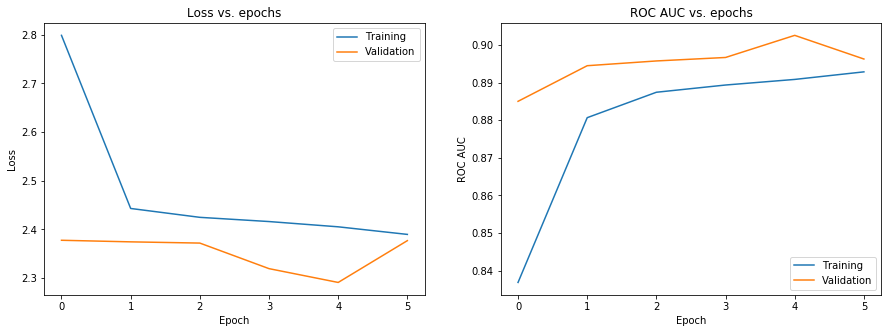

In [63]:
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(train_loss_results)
plt.plot(val_loss_results)
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)
plt.plot(train_roc_auc_results)
plt.plot(val_roc_auc_results)
plt.title('ROC AUC vs. epochs')
plt.ylabel('ROC AUC')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

### Test the model

Similarly, we can calculate the loss and metric values on the test dataset.

In [64]:
test_epoch_loss_avg = tf.keras.metrics.Mean()
test_epoch_roc_auc = tf.keras.metrics.AUC(curve='ROC')

In [65]:
for inputs, labels in test_ds:
    model_pred = model(inputs)
    test_epoch_loss_avg(loss(labels, model_pred))
    test_epoch_roc_auc(to_categorical(labels, num_classes=46), model_pred)
    
print("Test loss: {:.3f}".format(test_epoch_loss_avg.result()))
print("Test ROC AUC: {:.3%}".format(test_epoch_roc_auc.result()))

Test loss: 2.379
Test ROC AUC: 89.258%


### Further reading and resources

* https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough#training_loop
* https://www.tensorflow.org/api_docs/python/tf/keras/metrics
* https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve